In [5]:
"""pydca demo

Author: Mehari B. Zerihun
"""

# import pydca modules
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca import dca_utilities
import os
import pandas as pd
import numpy as np
from pathlib import Path
import ecc_tools as tools
import data_processing as dp
print(os.getcwd())

pfam_id = 'PF00186'
pfam_id = 'PF18577'
pfam_id = 'PF03678'
pfam_id = 'PF00186'
pfam_id = 'PF03496'

n_cpu = 20
method = "DI"
preprocess = False # do we want to preprocess FASTA files the same way as in DCA-ER method?

data_path = Path('Pfam-A.full')
DCA_ER_dir = '/data/cresswellclayec/DCA_ER/'
msa_npy_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
out_dir = '%sprotein_data/di/' % DCA_ER_dir
processed_data_dir = '%sprotein_data/data_processing_output' % DCA_ER_dir
pdb_data_dir = '%sprotein_data/pdb_data' % DCA_ER_dir



/gpfs/gsfs8/users/cresswellclayec/DCA_ER


In [6]:
def npy2fa_new(data_path, pfam_id, pdb_data_dir, index_pdb=0): # letter_format is True
    # creates output for pydca to use
    # (output generated from .npy MSA files generated by Pfam parsing)
    msa_dir = '%s/%s' % (data_path, pfam_id)
#     s = np.load('%s/msa.npy' % msa_dir).T
    s = dp.load_msa(data_path, pfam_id)
    
    # # ---- Get Reference Seq --------- # #
    # Use data processing to get selected PDB structure and reference sequence
    s0, removed_cols, s_index, tpdb, pdb_select \
= dp.data_processing_new(data_path, pfam_id, index_pdb=0,gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, 
                        conserved_cols=0.8, printing=True, out_dir='./', letter_format=True, 
                        remove_cols=False, create_new=True)
    
    # Use contact mapping to get pdb_chain..
    pdb_chain, ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range \
= tools.contact_map_new(pdb_id=pdb_select['PDB ID'][:4], pdb_range=[pdb_select['Subject Beg'], pdb_select['Subject End']], \
                  removed_cols=removed_cols, queried_seq=pdb_select['Subject Aligned Seq'],  pdb_out_dir=pdb_data_dir)
    

    ref_seq = pdb_select['Query Aligned Seq']
    pdb_seq = pdb_select['Subject Aligned Seq']
    query_seq = pdb_select['Query Aligned Seq']
    pdb_id = pdb_select['PDB ID']
    print('pdb_query Index: %d, vs data processing index (sequences removed): %d' % (pdb_select['MSA Index'],tpdb))
    # # -------------------------------- # #


    # # ------- Write to FASTA --------- # #
    # Next save MSA to FAST file
    print(msa_dir)
    if not preprocess:
        msa_outfile = Path(msa_dir, '%s_msa_raw.fa' % pfam_id)
    else:
        msa_outfile = Path(msa_dir, '%s_msa_preprocessed.fa' % pfam_id)

    with open(str(msa_outfile), 'w') as fh:
        for seq_num, seq in enumerate(s):
            msa_list = seq.tolist()
            msa_str = ''
            msa_str = msa_str.join(msa_list)
            if seq_num == tpdb:
                fasta_header = pfam_id + ' | REFERENCE'
            else:
                fasta_header = pfam_id + 'seq %d' % seq_num
            fh.write('>{}\n{}\n'.format(fasta_header, msa_str))
            
            
    # # ---- Get Reference Seq --------- # #                                                                                            
    
    print('Reference sequence (tpdb, s_ipdb) is sequence # %d' % tpdb)                                                                  
    gap_pdb = s[tpdb] == '-'  # returns True/False for gaps/no gaps in reference sequence                                           
    s_gap = s[:, ~gap_pdb]  # removes gaps in reference sequence
    ref_s = s_gap[tpdb]
    print("shape of s: ", s.shape)                                                                        
    print("shape of ref_s: ", ref_s.shape)
    # print(ref_s)
    print('poly_seq_range (%d): ' % len(poly_seq_range), poly_seq_range)
    print('poly_seq (%d): ' % len(poly_seq), poly_seq)

    # # -------------------------------- # #                                                                                            
    ref_outfile = Path(msa_dir, '%s_ref.fa' % pfam_id)
    with open(str(ref_outfile), 'w') as fh:
        ref_str = ''
#         ref_list = ref_s.tolist()
        ref_list = poly_seq
        ref_str = ref_str.join(ref_list)
        fh.write('>{}\n{}\n'.format(pfam_id + ' | REFERENCE', ref_str))
    print(len(ref_str))
        # Reference string now gotten from geting PDB match in ecc_tools.find_best_pdb()
#         fh.write('>{}\n{}\n'.format(pfam_id + ' | REFERENCE', ref_seq))
    # # -------------------------------- # #


    return msa_outfile, ref_outfile, s, pdb_select, pdb_chain

In [7]:
os.chdir(DCA_ER_dir)

msa_outfile, ref_outfile, s, pdb_select, pdb_chain= npy2fa_new(data_path, pfam_id, pdb_data_dir, index_pdb=0)
pdb_id = pdb_select['PDB ID'][:4]


Original Sequence length:  912
#

--------------------- Find Matching PDB Strucutre for MSA ----#
Raw-Query PDB dataframe gives 292 matches... 

Sorted PDB matches (24 matches): 
     Unnamed: 0  MSA Index  PDB ID  Score  Identity        E-value  Bitscore  \
0            1          1  2C89_1    1.0     1.000  6.401000e-122       385   
1          174        174  2C89_1    1.0     1.000  6.401000e-122       385   
2          143        143  6GNN_2    1.0     0.994  7.261000e-121       382   
3          269        269  2J3V_1    1.0     0.955  1.842000e-120       381   
4          365        365  2GWM_1    1.0     1.000  5.134000e-118       374   
5          130        130  2GWM_1    1.0     1.000  5.381000e-118       374   
6          151        151  3NTS_1    1.0     0.942  1.550000e-117       372   
7          265        265  2GWM_1    1.0     0.983  1.501000e-116       370   
8          305        305  6GN8_2    1.0     0.984  8.124000e-116       367   
9          325        325  5UR

Found Match!

TPLYREVNNYLRLQHENSGREAEIDNHDEKLSPHIKMLSSALNRLMDVAAFRGTVYRGIRGDLDTIARLYHLFDTGGRYVEPAFMSTTRIKDSAQVFEPGTPNNIAFQISLKRGADISGSSQAPSEEEIMLPMMSEFVIEHASALSEGKHL
TPLYREVNNYLRLQHENSGREAEIDNHDEKLSPHIKMLSSALNRLMDVAAFRGTVYRGIRGDLDTIARLYHLFDTGGRYVEPAFMSTTRIKDSAQVFEPGTPNNIAFQISLKRGADISGSSQAPSEEEIMLPMMSEFVIEHASALSEGKHL
pdb_query Index: 445, vs data processing index (sequences removed): 348
Pfam-A.full/PF03496
Reference sequence (tpdb, s_ipdb) is sequence # 348
shape of s:  (469, 912)
shape of ref_s:  (180,)
poly_seq_range (151):  ['T', 'P', 'L', 'Y', 'R', 'E', 'V', 'N', 'N', 'Y', 'L', 'R', 'L', 'Q', 'H', 'E', 'N', 'S', 'G', 'R', 'E', 'A', 'E', 'I', 'D', 'N', 'H', 'D', 'E', 'K', 'L', 'S', 'P', 'H', 'I', 'K', 'M', 'L', 'S', 'S', 'A', 'L', 'N', 'R', 'L', 'M', 'D', 'V', 'A', 'A', 'F', 'R', 'G', 'T', 'V', 'Y', 'R', 'G', 'I', 'R', 'G', 'D', 'L', 'D', 'T', 'I', 'A', 'R', 'L', 'Y', 'H', 'L', 'F', 'D', 'T', 'G', 'G', 'R', 'Y', 'V', 'E', 'P', 'A', 'F', 'M', 'S', 'T', 'T', 'R', 'I', 'K', 'D', 'S', '

In [8]:
print(pdb_select)
pdb_id = pdb_select['PDB ID'][:4]


Unnamed: 0                                                           445
MSA Index                                                            445
PDB ID                                                            3U0J_1
Score                                                                  1
Identity                                                               1
E-value                                                         4.36e-95
Bitscore                                                             305
Alignment Length                                                     151
Mismatches                                                             0
Gaps Opened                                                            0
Query Beg                                                              1
Query End                                                            151
Subject Beg                                                          114
Subject End                                        

In [9]:
# create MSATrimmer instance 
trimmer = msa_trimmer.MSATrimmer(
    str(msa_outfile), biomolecule='protein', 
    refseq_file=str(ref_outfile),
)

trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)

#write trimmed msa to file in FASTA format
trimmed_data_outfile = '%sprotein_data/data_processing_output/MSA_%s_Trimmed.fa' % (DCA_ER_dir, pfam_id)
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))

In [10]:
# Compute DCA scores using Pseudolikelihood maximization algorithm

plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'protein',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads =n_cpu,
    max_iterations = 500,
)

if preprocess:
    plm_out_file = '%s%s_%s_pydca_plm_preproc.npy' % (out_dir, pfam_id, method)
else:
    plm_out_file = '%s%s_%s_pydca_plm.npy' % (out_dir, pfam_id, method)

if 0: #os.path.exists(plm_out_file):
    plmdca_scores = np.load(plm_out_file)
else:
    # compute PLM DCA scores summarized by various methods:
    # FN_APC: Frobenius norm and average product corrected
    # DI_APC: raw DI with average product correction
    # DI: raw DI score
    # FN: Frobenius norm of raw DI
    if method == "DI_APC":
        plmdca_scores = plmdca_inst.compute_sorted_DI_APC()
    if method == "DI":
        plmdca_scores = plmdca_inst.compute_sorted_DI()
    if method == "FN_APC":
          plmdca_scores = plmdca_inst.compute_sorted_FN_APC()
    if method == "FN":
        plmdca_scores = plmdca_inst.compute_sorted_FN()


In [11]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    trimmed_data_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

if preprocess:
    mf_out_file = '%s%s_%s_pydca_mf_preproc.npy' % (out_dir, pfam_id, method)
else:
    mf_out_file = '%s%s_%s_pydca_mf.npy' % (out_dir, pfam_id, method)

if 0: #os.path.exists(mf_out_file):
    mfdca_scores = np.load(mf_out_file)
else:
    # compute MF DCA scores summarized by various methods:
    # FN_APC: Frobenius norm and average product corrected
    # DI_APC: raw DI with average product correction
    # DI: raw DI score
    # FN: Frobenius norm of raw DI
    if method == "DI_APC":
        mfdca_scores = mfdca_inst.compute_sorted_DI_APC()
    if method == "DI":
        mfdca_scores = mfdca_inst.compute_sorted_DI()
    if method == "FN_APC":
        mfdca_scores = mfdca_inst.compute_sorted_FN_APC()
    if method == "FN":
        mfdca_scores = mfdca_inst.compute_sorted_FN()

        

## Map Scores to PDB indexing 
Since there is no gaps in PDB match (by desing in ecc_tools.find_best_pdb()) we simply shift the PYDCA score index by the differnece in the start indices of the subject (PDB) and query (MSA) sequences obtained in ecc_tools.find_best_pdb()

In [21]:
mfdca_scores_adjusted = []
plmdca_scores_adjusted = []
indx_diff = pdb_select['Subject Beg'] - pdb_select['Query Beg']
indx_diff = 0
# print(indx_diff)
for ((i,j), score) in plmdca_scores:
    plmdca_scores_adjusted.append(((i+indx_diff, j+indx_diff), score))
for ((i,j), score) in mfdca_scores:
    mfdca_scores_adjusted.append(((i+indx_diff, j+indx_diff), score))

In [22]:
plmdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = plmdca_scores_adjusted,
    linear_dist = 4,
    contact_dist = 5.0,
)

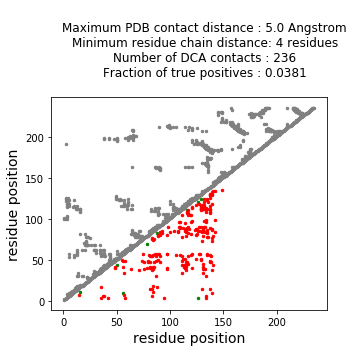

In [23]:
contact_map_data = plmdca_visualizer.plot_contact_map()

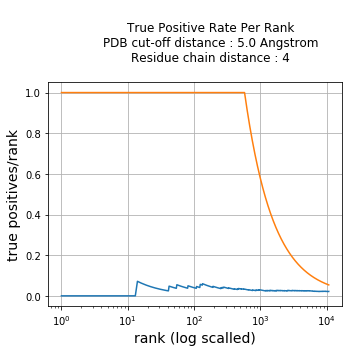

In [24]:
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()

In [25]:
mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = str(ref_outfile),
    sorted_dca_scores = mfdca_scores_adjusted,
    linear_dist = 4,
    contact_dist = 5.0,
)

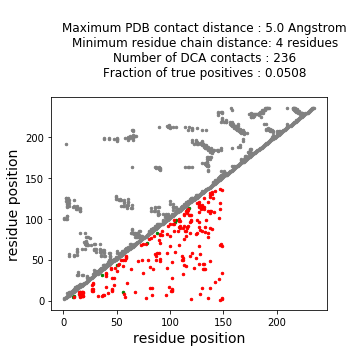

In [26]:
contact_map_data = mfdca_visualizer.plot_contact_map()

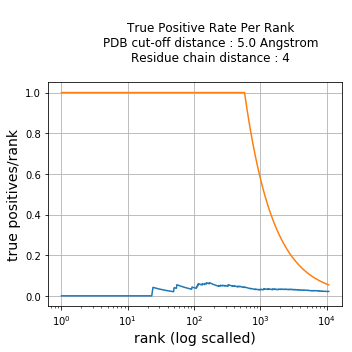

In [27]:
tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

In [28]:
np.save(plm_out_file, plmdca_scores_adjusted)
np.save(mf_out_file, mfdca_scores_adjusted)